# Agentic Customer Lifetime Value (LTV) Prediction

## Project Overview
This project develops an agentic LTV prediction solution using retrieval-augmented reasoning and local LLM agents to combine structured customer/policy data with contextual document evidence.

## Step 1: Data Exploration & Preprocessing

### Objective
- Load and examine customer demographics, policy details, premium & payment history, claim history, and renewal/retention records
- Augment with document corpus: policy wording, underwriting notes, correspondence and case summaries
- Clean and preprocess data for LTV modeling

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import json
import os
from pathlib import Path

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


Libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 2.3.3


In [2]:
def generate_insurance_dataset_realistic_v2(
    n_customers: int = 5000,
    start_date: str = "2020-01-01",
    end_date: str = "2024-12-31",
    seed: int = 42,
    correlation_strength: float = 0.6,
    return_metadata: bool = False,
) -> pd.DataFrame:
    """
    Generate a realistic synthetic insurance dataset for LTV modeling and agent reasoning.

    Improvements vs v1:
    - Fixed invalid datetime arithmetic for last_claim_date
    - Balanced renewal probabilities (realistic churn rate)
    - Smoothed claim distribution over tenure
    - Age–income correlation calibrated with moderate strength
    - Ensured consistency between churn and LTV
    - Added temporal and behavioral feature fields
    """

    np.random.seed(seed)
    correlation_strength = np.clip(correlation_strength, 0.0, 0.95)

    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)

    # --- Demographics with true correlated age–income generation
    mean = [0, 0]
    cov = [[1, correlation_strength], [correlation_strength, 1]]
    z_age, z_income = np.random.multivariate_normal(mean, cov, n_customers).T

    ages = np.clip((z_age * 12 + 45).astype(int), 18, 85)
    income_levels = np.exp(z_income * 0.3) * (25000 + 600 * ages)
    income_levels *= np.random.lognormal(0, 0.2, n_customers)
    income_levels = np.clip(income_levels, 20000, 250000)

    genders = np.random.choice(["M", "F"], n_customers, p=[0.52, 0.48])
    regions = np.random.choice(["Urban", "Suburban", "Rural"], n_customers, p=[0.4, 0.45, 0.15])

    # --- Policy type influenced by income
    income_scaled = (income_levels - income_levels.min()) / (income_levels.max() - income_levels.min())
    policy_types = []
    for s in income_scaled:
        p = np.array([
            0.55 - 0.10 * s,  # Auto
            0.25 + 0.10 * s,  # Home
            0.10 + 0.08 * s,  # Life
            0.10,             # Health
        ])
        p = np.clip(p, 0, None)
        p /= p.sum()
        policy_types.append(np.random.choice(["Auto", "Home", "Life", "Health"], p=p))
    policy_types = np.array(policy_types)

    # --- Premiums correlated with policy & income
    base_premiums = {"Auto": 800, "Home": 1600, "Life": 2000, "Health": 1200}
    premium_base = np.array([base_premiums[p] for p in policy_types])
    premium_amount = premium_base * (1 + (income_levels / 150000) ** 0.5 * 0.5)
    premium_amount *= np.random.lognormal(0, 0.25, n_customers)
    premium_amount = np.clip(premium_amount, 300, 10000)

    # --- Policy tenure (months)
    tenure_months = np.clip(np.random.exponential(30, n_customers), 3, 84)

    # Ensure policy_start_date + tenure <= end_date
    max_start = end - pd.to_timedelta(tenure_months * 30, unit="D")
    max_start = pd.Series(max_start)
    max_days = (max_start - start).dt.days.clip(lower=1)
    policy_start_dates = start + pd.to_timedelta(
        np.random.randint(0, max_days.values, n_customers), unit="D"
    )
    policy_end_dates = policy_start_dates + pd.to_timedelta(tenure_months * 30, unit="D")
    policy_end_dates = pd.Series(policy_end_dates).clip(upper=end)

    # --- Payment behavior
    payment_freq = np.random.choice(["Monthly", "Quarterly", "Annual"], n_customers, p=[0.6, 0.25, 0.15])
    payment_regularity = np.clip(np.random.beta(4, 1.5, n_customers) + np.random.normal(0, 0.05, n_customers), 0.3, 1.0)

    # --- Claims
    base_claim_rate = np.where(ages < 25, 0.25, np.where(ages > 65, 0.18, 0.1))
    policy_factor = np.array([
        1.4 if p == "Auto" else 1.0 if p == "Health" else 0.8 if p == "Home" else 0.6
        for p in policy_types
    ])
    claim_lambda = base_claim_rate * policy_factor * np.sqrt(tenure_months / 12)
    num_claims = np.random.poisson(claim_lambda)
    num_claims = np.clip(num_claims, 0, 15)

    # --- Claim costs (conditional)
    claim_cost_params = {"Auto": (7.8, 0.9), "Home": (8.3, 0.8), "Life": (9.0, 0.6), "Health": (8.0, 1.0)}
    claim_costs = np.zeros(n_customers)
    for p in claim_cost_params:
        idx = (policy_types == p) & (num_claims > 0)
        claim_costs[idx] = num_claims[idx] * np.random.lognormal(*claim_cost_params[p], size=idx.sum())

    # --- Renewal probability (balanced)
    logits = (
        0.5
        - 0.03 * (ages - 45)
        - 0.4 * num_claims
        + 1.2 * payment_regularity
        + 0.005 * tenure_months
        + np.random.normal(0, 0.5, n_customers)
    )
    renewal_prob = 1 / (1 + np.exp(-logits))
    renewal_prob = np.clip(renewal_prob, 0.05, 0.95)

    churned = np.random.binomial(1, 1 - renewal_prob)

    # --- Last claim date (bounded between start & end)
    has_claims = num_claims > 0
    last_claim_date = np.full(n_customers, np.datetime64('NaT'), dtype="datetime64[ns]")
    last_claim_date[has_claims] = (
        policy_end_dates[has_claims] - pd.to_timedelta(np.random.exponential(180, has_claims.sum()), unit="D")
    )
    last_claim_date = pd.to_datetime(last_claim_date)
    last_claim_date = pd.Series(last_claim_date).clip(lower=policy_start_dates, upper=policy_end_dates)

    # --- Customer Lifetime Value (controlled)
    expected_value = premium_amount * (tenure_months / 12)
    ltv = expected_value * renewal_prob
    ltv[churned == 1] *= np.random.uniform(0.1, 0.5, churned.sum())
    ltv *= np.maximum(1 - np.minimum(claim_costs / (expected_value + 1e-6), 0.8), 0.2)
    ltv = np.clip(ltv, 0, 250_000)

    # --- Derived temporal features
    policy_age_days = (policy_end_dates - policy_start_dates).dt.days
    days_since_last_claim = (policy_end_dates - last_claim_date).dt.days.where(has_claims, np.nan)
    is_active = (policy_end_dates >= end).astype(int)

    # --- Final DataFrame
    df = pd.DataFrame({
        "customer_id": [f"CUST_{i:05d}" for i in range(1, n_customers + 1)],
        "age": ages,
        "gender": genders,
        "region": regions,
        "income_level": np.round(income_levels, 2),
        "policy_type": policy_types,
        "premium_amount": np.round(premium_amount, 2),
        "payment_frequency": payment_freq,
        "payment_regularity": np.round(payment_regularity, 3),
        "tenure_months": np.round(tenure_months, 1),
        "num_claims": num_claims,
        "claim_costs": np.round(claim_costs, 2),
        "policy_start_date": policy_start_dates,
        "policy_end_date": policy_end_dates,
        "last_claim_date": last_claim_date,
        "renewal_probability": np.round(renewal_prob, 3),
        "churned": churned,
        "customer_ltv": np.round(ltv, 2),
        "policy_age_days": policy_age_days,
        "days_since_last_claim": days_since_last_claim,
        "is_active": is_active,
    })

    if return_metadata:
        metadata = {
            "n_customers": n_customers,
            "start_date": start_date,
            "end_date": end_date,
            "seed": seed,
            "correlation_strength": correlation_strength,
            "generated_on": pd.Timestamp.now().isoformat(),
        }
        return df, metadata

    return df


In [3]:
import uuid
import random
from datetime import datetime, timedelta
from textwrap import shorten

def generate_document_corpus_v2(
    customers_df: pd.DataFrame = None,
    n_docs: int = 60,
    start_date: str = "2020-01-01",
    end_date: str = "2024-12-31",
    seed: int = 42,
    verbose: bool = False,
    max_passage_words: int = 200,
) -> pd.DataFrame:
    """
    Generate a synthetic document corpus aligned with a customer/policy dataset.

    Features:
      - Optional linking to customers_df: attaches policy_id / customer_id where relevant
      - Category/subtype normalized across all docs
      - created_date sampled between start_date and end_date (can align to policy dates)
      - Topic-aware keywords and longer contextual text for better retrieval
      - Passage splitting (if text long) and stable doc_id / passage_id scheme
      - Returns DataFrame ready for embedding + indexing with metadata fields:
        ['doc_id', 'passage_id', 'policy_id', 'customer_id', 'category', 'subtype',
         'source', 'created_date', 'text', 'keywords']
    """
    np.random.seed(seed)
    random.seed(seed)

    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    total_days = max(1, (end - start).days)

    # --- Helper maps for realistic keyword selection and template context
    kw_map = {
        "Auto": ["auto", "vehicle", "driver", "collision", "telematics", "premium"],
        "Home": ["home", "property", "dwelling", "flood", "fire", "repair", "inspection"],
        "Life": ["life", "beneficiary", "term", "payout", "underwriting", "medical"],
        "Health": ["health", "hospital", "claim", "copay", "provider", "network"],
        "General": ["renewal", "notice", "payment", "correspondence", "policy", "update"],
        "Underwriting": ["risk", "score", "medical", "credit", "assessment"],
        "CaseSummary": ["case", "resolution", "retention", "offer", "outcome"],
        "Product": ["product", "plan", "feature", "tier", "update"],
    }

    # --- Base templates (category, subtype, body_template)
    base_templates = [
        ("Auto", "Policy Wording",
         "This Auto policy includes comprehensive, collision and liability coverages. Deductibles and premium adjustments depend on driver age, claim history, and telematics scores. {extra}"),
        ("Home", "Policy Wording",
         "This Home policy covers dwelling, personal property and loss-of-use. Coverage limits and exclusions depend on construction type and local hazards. {extra}"),
        ("Life", "Policy Wording",
         "Term and whole-life options are available. Premiums and eligibility depend on medical underwriting and beneficiary designation. {extra}"),
        ("Health", "Policy Wording",
         "Tiered health plans (Bronze/Silver/Gold) with varying provider networks and out-of-pocket limits. Pre-authorization required for selected services. {extra}"),

        ("General", "Renewal Notice",
         "Your policy is due for renewal on {policy_end_date}. Please review updated premium and coverage information. {extra}"),
        ("General", "Premium Notice",
         "We are notifying you of a premium change effective {effective_date} due to regional claim trends. {extra}"),
        ("Underwriting", "Underwriting Note",
         "Underwriting analysis: risk factors include {risk_factors}. Recommends class change: {recommendation}. {extra}"),
        ("CaseSummary", "Retention Case",
         "Case summary: Customer was at risk due to recent claims; retention offer included a targeted discount and service outreach. Outcome: {outcome}. {extra}"),
        ("Product", "Product Update",
         "Product update: New telematics discount launched. Eligible customers will receive communication and opt-in instructions. {extra}"),
        ("General", "Claim Update",
         "Claim {claim_ref} is being processed. Current status: {status}. Estimated settlement: {estimate}. {extra}"),
    ]

    # --- If customers_df provided, create quick lookup of some policy/customer ids for linking
    policy_links = []
    if customers_df is not None and "policy_type" in customers_df.columns:
        # sample some (policy_id optional) — create synthetic policy_id if not present
        if "policy_start_date" in customers_df.columns:
            # use existing dates if available
            customers_df = customers_df.copy()
        # ensure we have an id to link
        if "policy_id" not in customers_df.columns:
            customers_df["policy_id"] = [f"P{100000 + i}" for i in range(len(customers_df))]
        policy_links = customers_df[["customer_id", "policy_id", "policy_type", "policy_start_date", "policy_end_date"]].to_dict("records")
    else:
        # Minimal generic pool to link
        policy_links = [{"customer_id": None, "policy_id": None, "policy_type": random.choice(["Auto","Home","Life","Health"]),
                         "policy_start_date": start + timedelta(days=random.randint(0, total_days//2)),
                         "policy_end_date": start + timedelta(days=random.randint(total_days//2, total_days))} for _ in range(200)]

    # --- Build a diverse pool of documents by instantiating templates with contextual fields
    all_docs = []
    for (category, subtype, template) in base_templates:
        for i in range(3):  # multiple variants per template
            extra_phrases = [
                "This language was updated to reflect regulatory guidance.",
                "This clause applies only to new business issued within the last 12 months.",
                "Refer to underwriting manual section 4.2 for scoring rules.",
                "This is a summary and not a full contract; see full policy wording for exclusions."
            ]
            extra = random.choice(extra_phrases)
            
            # Define safe placeholder defaults
            safe_kwargs = dict(
                extra=extra,
                policy_end_date="2024-12-31",
                effective_date="2024-01-01",
                risk_factors="driver age, credit score",
                recommendation="standard",
                outcome="retained",
                claim_ref=f"CLM{random.randint(10000,99999)}",
                status="in progress",
                estimate="$1500"
            )

            # Use safe format with defaults
            try:
                body = template.format(**safe_kwargs)
            except KeyError:
                # fallback: if any placeholder missing, ignore formatting
                body = template

            all_docs.append({
                "category": category if category in kw_map else "General",
                "subtype": subtype,
                "text": body
            })
    
    # Add some natural-language-like correspondence and case summaries from lists
    # (short examples expanded for realism)
    correspondence_examples = [
        ("General", "Customer Email", "Dear customer, we noticed a missed payment and would like to help you restore coverage. {extra}"),
        ("General", "Agent Note", "Phone call: discussed billing options and possible discounts. Customer expressed concern about recent rate change. {extra}")
    ]
    for cat, st, t in correspondence_examples:
        all_docs.append({"category": cat, "subtype": st, "text": t.format(extra="Please contact us at 1-800-EXAMPLE.")})

    # Expand to reach n_docs with controlled variation
    while len(all_docs) < n_docs:
        sample = random.choice(all_docs)
        variation = sample.copy()
        rev = random.randint(1, 5)
        change = random.choice([
            "Updated rates",
            "Coverage change",
            "New clause added",
            "Review summary",
            "Clarified exclusions",
        ])
        variation["text"] = f"{variation['text']} (Revision {rev}: {change})."
        all_docs.append(variation)

    # If more than n_docs, pick a balanced sample ensuring category coverage
    if len(all_docs) > n_docs:
        # ensure at least one doc per major category
        categories = list(set([d["category"] for d in all_docs]))
        chosen = []
        # pick one per category first
        for c in categories:
            candidates = [d for d in all_docs if d["category"] == c]
            chosen.append(random.choice(candidates))
        # fill rest randomly
        remaining = n_docs - len(chosen)
        others = [d for d in all_docs if d not in chosen]
        chosen.extend(random.sample(others, remaining))
        all_docs = chosen

    random.shuffle(all_docs)

    # --- instantiate final corpus with metadata and possible links
    corpus = []
    for i, doc in enumerate(all_docs, start=1):
        uid = uuid.uuid4().hex[:8].upper()
        doc_id = f"DOC_{uid}"
        # sample a link: 40% chance to tie to an actual policy if available
        link = random.choice(policy_links)
        linked_policy = link["policy_id"] if random.random() < 0.4 else None
        linked_customer = link["customer_id"] if linked_policy is not None else None
        # created_date: if linked to a policy, favor its lifecycle; otherwise uniform
        if linked_policy and link.get("policy_start_date") is not None and link.get("policy_end_date") is not None:
            p_start = pd.to_datetime(link["policy_start_date"])
            p_end = pd.to_datetime(link["policy_end_date"])
            if pd.isna(p_start) or pd.isna(p_end) or p_end <= p_start:
                created_date = start + timedelta(days=random.randint(0, total_days))
            else:
                created_date = p_start + timedelta(days=random.randint(0, max(1, (p_end - p_start).days)))
        else:
            created_date = start + timedelta(days=random.randint(0, total_days))

        # source (internal/agent/customer-facing) derived from subtype
        source = "internal" if doc["subtype"] in ("Underwriting Note", "Agent Note", "CaseSummary") else random.choice(["customer-facing", "internal", "agent-note"])

        # keywords selected from kw_map or generic terms, biased by category
        kw_pool = kw_map.get(doc["category"], kw_map["General"])
        keywords = random.sample(kw_pool, k=min(len(kw_pool), random.randint(3, 5)))

        # craft a slightly longer text for retrieval: repeat + add context sentences
        context_sentences = [
            "This excerpt summarizes the key points relevant to pricing and retention.",
            "Please refer to the full policy for exact conditions and exclusions.",
            "Contact the underwriting team for clarifications on risk assessment.",
            "This note was generated as part of an automated review process."
        ]
        text = doc["text"]
        # append 1-2 contextual sentences
        text += " " + " ".join(random.sample(context_sentences, k=random.randint(1, 2)))
        # ensure text not too long: truncate gracefully
        text = shorten(text, width=800, placeholder=" ...")

        # split into passages if long (simple word-based split)
        words = text.split()
        passages = []
        if len(words) <= max_passage_words:
            passages = [text]
        else:
            for start_idx in range(0, len(words), max_passage_words):
                passage = " ".join(words[start_idx:start_idx + max_passage_words])
                passages.append(passage)

        for p_idx, passage in enumerate(passages, start=1):
            passage_id = f"{doc_id}_P{p_idx:02d}"
            corpus.append({
                "doc_id": doc_id,
                "passage_id": passage_id,
                "policy_id": linked_policy,
                "customer_id": linked_customer,
                "category": doc["category"],
                "subtype": doc["subtype"],
                "source": source,
                "created_date": created_date,
                "created_date_str": created_date.strftime("%Y-%m-%d"),
                "text": passage,
                "keywords": keywords,
            })

    corpus_df = pd.DataFrame(corpus)

    if verbose:
        print(f" Generated document corpus: {len(corpus_df)} passages from {len(all_docs)} docs")
        print(f"Categories: {sorted(corpus_df['category'].unique().tolist())}")
        if len(corpus_df) > 0:
            print("Example passage metadata:")
            print(corpus_df.iloc[0].to_dict())

    return corpus_df


## 1.1 Load and Inspect Data

- Understand structure and distribution of core numerical and categorical variables.

- Verify consistency of keys (customer_id, policy_id).

- Inspect sample text content for variety and completeness.

In [4]:
# Generate synthetic datasets
customers_df, metadata = generate_insurance_dataset_realistic_v2(return_metadata=True)
docs_df = generate_document_corpus_v2(customers_df=customers_df, n_docs=80)

print(" Data loaded successfully.")
print(f"Customers: {len(customers_df):,} | Docs: {len(docs_df):,}")
display(customers_df.head(3))
display(docs_df.head(3))

 Data loaded successfully.
Customers: 5,000 | Docs: 80


,customer_id,age,gender,region,income_level,policy_type,premium_amount,payment_frequency,payment_regularity,tenure_months,...,claim_costs,policy_start_date,policy_end_date,last_claim_date,renewal_probability,churned,customer_ltv,policy_age_days,days_since_last_claim,is_active
0,CUST_00001,40,M,Urban,36755.54,Home,1508.38,Monthly,0.494,16.5,...,6341.0,2020-01-15,2021-05-23 09:57:05.105568228,2021-04-08 01:35:32.530304391,0.789,0,326.88,494,45.0,0
1,CUST_00002,29,M,Suburban,41123.98,Health,1036.90,Quarterly,0.861,13.1,...,0.0,2020-12-06,2022-01-02 08:27:01.498789108,NaT,0.830,0,938.37,392,NaN,0
2,CUST_00003,48,F,Urban,49265.03,Auto,1133.57,Monthly,0.651,49.4,...,0.0,2020-06-01,2024-06-21 15:18:25.064825535,NaT,0.840,0,3920.60,1481,NaN,0


,doc_id,passage_id,policy_id,customer_id,category,subtype,source,created_date,created_date_str,text,keywords
0,DOC_AE2A6DB3,DOC_AE2A6DB3_P01,P101268,CUST_01269,Health,Policy Wording,customer-facing,2022-01-26,2022-01-26,Tiered health plans (Bronze/Silver/Gold) with ...,"[network, provider, health, claim, hospital]"
1,DOC_22921DCA,DOC_22921DCA_P01,None,None,CaseSummary,Retention Case,agent-note,2024-10-12,2024-10-12,Case summary: Customer was at risk due to rece...,"[case, outcome, offer]"
2,DOC_7B027310,DOC_7B027310_P01,None,None,Product,Product Update,agent-note,2024-12-28,2024-12-28,Product update: New telematics discount launch...,"[update, product, feature]"


## 1.2 Numerical Summaries & Distributions

In [5]:
# Summary statistics

print("\n Customers dataset shape:", customers_df.shape)
print(" Document corpus shape:", docs_df.shape)

display(customers_df.describe(include='all').T.head(15))



 Customers dataset shape: (5000, 21)
 Document corpus shape: (80, 11)


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
customer_id,5000,5000,CUST_00001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,5000.0,NaN,NaN,NaN,44.5984,18.0,36.0,45.0,53.0,85.0,11.878423
gender,5000,2,M,2536,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,5000,3,Suburban,2292,NaN,NaN,NaN,NaN,NaN,NaN,NaN
income_level,5000.0,NaN,NaN,NaN,56888.406012,20000.0,38197.0275,51912.17,69773.37,250000.0,26205.812206
policy_type,5000,4,Auto,2637,NaN,NaN,NaN,NaN,NaN,NaN,NaN
premium_amount,5000.0,NaN,NaN,NaN,1579.603932,407.71,1016.07,1362.535,2006.455,7053.35,740.842735
payment_frequency,5000,3,Monthly,2971,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payment_regularity,5000.0,NaN,NaN,NaN,0.728177,0.3,0.612,0.755,0.866,1.0,0.176463
tenure_months,5000.0,NaN,NaN,NaN,28.23712,3.0,8.4,20.4,42.0,84.0,24.261803


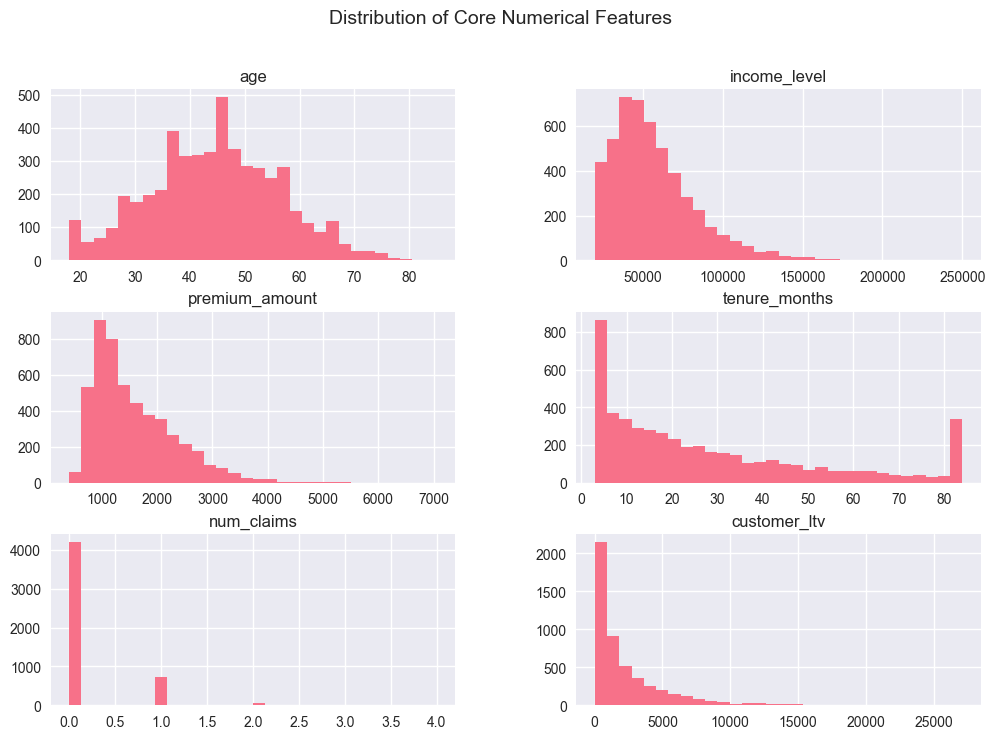

In [6]:
# --- Visualize core numerical features
num_cols = ["age", "income_level", "premium_amount", "tenure_months", "num_claims", "customer_ltv"]
existing_cols = [c for c in num_cols if c in customers_df.columns]

customers_df[existing_cols].hist(bins=30, figsize=(12, 8))
plt.suptitle("Distribution of Core Numerical Features", fontsize=14)
plt.show()

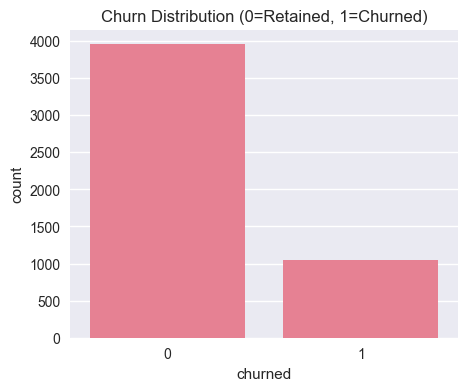

In [7]:
# Retention and churn overview
plt.figure(figsize=(5,4))
sns.countplot(x="churned", data=customers_df)
plt.title("Churn Distribution (0=Retained, 1=Churned)")
plt.show()


## 1.3 Data Cleaning & Normalization

In [8]:
# Advanced clean + normalize

import logging
from typing import Tuple, Dict

from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression

# configure logger
logger = logging.getLogger("advanced_clean_normalize")
if not logger.handlers:
    handler = logging.StreamHandler()
    formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
    handler.setFormatter(formatter)
    logger.addHandler(handler)
logger.setLevel(logging.INFO)


def advanced_clean_normalize_v2(
    df: pd.DataFrame,
    impute_strategy: str = "group_median",  # "group_median" or "global_median"
    rolling_window: int = 6,
    iso_contamination: float = 0.02,
    min_records_for_iso: int = 50,
    detrend_min_per_group: int = 5,
    verbose: bool = True,
) -> Tuple[pd.DataFrame, Dict]:
    """
    Robust cleaning & normalization pipeline for insurance LTV datasets.

    Returns:
        cleaned_df, summary_dict

    Key steps:
      1. Safe date normalization & consistency fixes
      2. Missing value handling (group median with global fallback)
      3. Robust outlier treatment (IQR + modified z-score + special handling for zero-inflated claim_costs)
      4. Rolling smoothing per-customer (mean/std/zscore) — corrected implementation
      5. Linear detrending (per-customer if possible, else global) with safe masking
      6. Multivariate anomaly detection (IsolationForest) with guards for small datasets
      7. Safe normalization and log transforms with clipping
      8. Duplicate removal & final summary
    """

    # copy input
    df = df.copy(deep=True)

    # summary containers
    summary = {
        "n_input_rows": int(len(df)),
        "missing_date_counts": {},
        "imputed_columns": {},
        "outlier_summary": {},
        "detrend_info": {"per_customer_applied": 0, "global_applied": 0},
        "n_anomalies": 0,
        "final_rows": None,
    }

    # ---------- 0. Basic checks ----------
    if df.empty:
        logger.warning("Input dataframe is empty — returning empty outputs.")
        return df, summary

    # ensure expected id column exists
    if "customer_id" not in df.columns:
        logger.info("No 'customer_id' column found — creating synthetic customer_id index.")
        df["customer_id"] = [f"CUST_{i:06d}" for i in range(len(df))]

    # ---------- 1. Date normalization & consistency ----------
    date_cols = ["policy_start_date", "policy_end_date", "last_claim_date"]
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce")
            n_missing = int(df[col].isna().sum())
            summary["missing_date_counts"][col] = n_missing
            if verbose:
                logger.info(f"Column '{col}': coerced to datetime, missing {n_missing} rows.")

    # fix end < start by setting end = start (safe)
    if {"policy_start_date", "policy_end_date"}.issubset(df.columns):
        mask_bad = df["policy_end_date"] < df["policy_start_date"]
        n_bad = int(mask_bad.sum())
        if n_bad > 0:
            df.loc[mask_bad, "policy_end_date"] = df.loc[mask_bad, "policy_start_date"]
            logger.info(f"Fixed {n_bad} rows with policy_end_date < policy_start_date.")

    # ---------- 2. Missing value handling ----------
    # target impute columns
    impute_cols = [c for c in ["income_level", "premium_amount", "claim_costs"] if c in df.columns]
    for col in impute_cols:
        try:
            if impute_strategy == "group_median" and "policy_type" in df.columns:
                # group median, fallback to global median
                df[col] = df.groupby("policy_type")[col].transform(lambda x: x.fillna(x.median()))
                global_median = df[col].median()
                df[col] = df[col].fillna(global_median)
                summary["imputed_columns"][col] = {"strategy": "group_median_with_global_fallback", "global_median": float(global_median)}
            else:
                global_median = df[col].median()
                df[col] = df[col].fillna(global_median)
                summary["imputed_columns"][col] = {"strategy": "global_median", "global_median": float(global_median)}
            if verbose:
                logger.info(f"Imputed column '{col}' with strategy {summary['imputed_columns'][col]['strategy']}.")
        except Exception as e:
            logger.warning(f"Imputation failed for {col}: {e}")
            df[col] = df[col].fillna(0.0)
            summary["imputed_columns"][col] = {"strategy": "fill_zero_due_to_error"}

    # also flag missing_last_claim
    df["missing_last_claim"] = (df.get("last_claim_date").isna() if "last_claim_date" in df.columns else True).astype(int)

    # ---------- 3. Robust outlier detection & capping ----------
    def iqr_filter_mask(series, k=1.5):
        q1, q3 = series.quantile([0.25, 0.75])
        iqr = q3 - q1
        if iqr == 0:
            return pd.Series(True, index=series.index)
        return series.between(q1 - k * iqr, q3 + k * iqr)

    def modified_zscore_mask(series, thresh=3.5):
        med = series.median()
        mad = (series - med).abs().median()
        if mad == 0:
            return pd.Series(True, index=series.index)
        z = 0.6745 * (series - med) / mad
        return z.abs() < thresh

    numeric_cols = [c for c in ["income_level", "premium_amount", "claim_costs", "customer_ltv"] if c in df.columns]

    for col in numeric_cols:
        try:
            s = df[col].dropna()
            if s.empty:
                summary["outlier_summary"][col] = {"note": "empty_column"}
                continue

            if col == "claim_costs":
                # zero-inflated special handling
                nz_mask = s > 0
                if nz_mask.sum() >= 10:
                    nz = s[nz_mask]
                    low, high = nz.quantile([0.01, 0.99])
                    df.loc[nz.index, col] = nz.clip(low, high)
                    n_out = int(((nz > high) | (nz < low)).sum())
                    summary["outlier_summary"][col] = {"n_outliers": n_out, "lower_cap": float(low), "upper_cap": float(high)}
                else:
                    summary["outlier_summary"][col] = {"n_outliers": 0, "note": "too_few_nonzero"}
                continue

            # regular numeric columns: combine masks
            mask_iqr = iqr_filter_mask(s, k=2.0)
            mask_mz = modified_zscore_mask(s, thresh=3.5)
            combined_mask = mask_iqr & mask_mz
            # compute caps using the non-outlier subset to limit extreme influence
            safe_low, safe_high = s[combined_mask].quantile([0.01, 0.99])
            # fallback if combined_mask is all False or NaN
            if pd.isna(safe_low) or pd.isna(safe_high):
                safe_low, safe_high = s.quantile([0.01, 0.99])
            df.loc[s.index, col] = s.clip(safe_low, safe_high)
            n_outliers = int((~combined_mask).sum())
            summary["outlier_summary"][col] = {"n_outliers": n_outliers, "lower_cap": float(safe_low), "upper_cap": float(safe_high)}
        except Exception as e:
            logger.exception(f"Outlier handling failed for {col}: {e}")
            summary["outlier_summary"][col] = {"error": str(e)}

    # ---------- 4. Rolling smoothing per-customer (corrected) ----------
    def rolling_features_safe(df_in, id_col="customer_id", date_col="policy_start_date", cols=None, window=rolling_window):
        if cols is None or len(cols) == 0:
            return df_in
        df_sorted = df_in.sort_values([id_col, date_col]).copy()
        for col in cols:
            roll_mean_col = f"{col}_roll_mean"
            roll_std_col = f"{col}_roll_std"
            z_col = f"{col}_zscore"
            # groupby transform on the sorted dataframe
            df_sorted[roll_mean_col] = df_sorted.groupby(id_col)[col].transform(lambda x: x.rolling(window, min_periods=1).mean())
            df_sorted[roll_std_col] = df_sorted.groupby(id_col)[col].transform(lambda x: x.rolling(window, min_periods=1).std().fillna(0.0))
            df_sorted[z_col] = (df_sorted[col] - df_sorted[roll_mean_col]) / (df_sorted[roll_std_col] + 1e-6)
            # fill NaN z-scores with 0
            df_sorted[z_col] = df_sorted[z_col].fillna(0.0)
        return df_sorted

    rolling_cols = [c for c in ["premium_amount", "claim_costs", "customer_ltv"] if c in df.columns]
    if rolling_cols:
        df = rolling_features_safe(df, cols=rolling_cols, window=rolling_window)
        if verbose:
            logger.info(f"Applied rolling smoothing for cols: {rolling_cols} (window={rolling_window}).")

    # ---------- 5. Detrending (per-customer if possible, else global) ----------
    def detrend_per_customer(df_in, date_col="policy_start_date", value_col="customer_ltv", min_per_group=detrend_min_per_group):
        df_out = df_in.copy()
        applied_groups = 0
        if date_col not in df_out.columns or value_col not in df_out.columns:
            return df_out, applied_groups

        # prepare numeric time vector: days since min date per dataset
        global_min_date = df_out[date_col].min()
        if pd.isna(global_min_date):
            return df_out, applied_groups

        # compute t (days) for all rows (will be used per-group)
        df_out["_t_global"] = (df_out[date_col] - global_min_date).dt.days.astype(float)

        # perform per-customer detrend where enough rows exist
        for cust, sub in df_out.groupby("customer_id"):
            mask = sub[value_col].notna() & sub[date_col].notna()
            if mask.sum() >= min_per_group:
                t = sub.loc[mask, "_t_global"].values.reshape(-1, 1)
                y = sub.loc[mask, value_col].values
                try:
                    reg = LinearRegression().fit(t, y)
                    trend = reg.predict(sub["_t_global"].values.reshape(-1, 1))
                    df_out.loc[sub.index, f"{value_col}_detrended"] = sub[value_col] - trend
                    applied_groups += 1
                except Exception:
                    # fallback: leave original
                    df_out.loc[sub.index, f"{value_col}_detrended"] = sub[value_col]
            else:
                df_out.loc[sub.index, f"{value_col}_detrended"] = sub[value_col]

        # global fallback: if no per-customer applied at all and enough global records, apply global detrend
        if applied_groups == 0:
            mask_all = df_out[value_col].notna() & df_out["_t_global"].notna()
            if mask_all.sum() >= 10:
                try:
                    reg = LinearRegression().fit(df_out.loc[mask_all, ["_t_global"]], df_out.loc[mask_all, value_col])
                    trend = reg.predict(df_out[["_t_global"]])
                    df_out[f"{value_col}_detrended"] = df_out[value_col] - trend
                    return df_out.drop(columns=["_t_global"]), 0  # global applied indicated by summary below
                except Exception:
                    df_out[f"{value_col}_detrended"] = df_out[value_col]
        return df_out.drop(columns=["_t_global"]), applied_groups

    for col in ["claim_costs", "customer_ltv"]:
        if col in df.columns and "policy_start_date" in df.columns:
            df, applied = detrend_per_customer(df, date_col="policy_start_date", value_col=col, min_per_group=detrend_min_per_group)
            if applied > 0:
                summary["detrend_info"]["per_customer_applied"] += int(applied)
                logger.info(f"Detrending applied per-customer for {col} on {applied} customers.")
            else:
                summary["detrend_info"]["global_applied"] += 1
                logger.info(f"Global detrending applied for {col} (per-customer not applied).")

    # ---------- 6. Multivariate anomaly detection (IsolationForest) ----------
    features = [c for c in ["income_level", "premium_amount", "claim_costs", "num_claims", "tenure_months"] if c in df.columns]
    # clean feature matrix: fill NaN with median and ensure numeric types
    X = None
    if len(features) >= 3 and len(df) >= 5:
        X = df[features].copy()
        for c in X.columns:
            if X[c].isna().any():
                X[c] = X[c].fillna(X[c].median())
        # enforce numeric types
        X = X.apply(pd.to_numeric, errors="coerce").fillna(0.0)
        # guard small datasets
        if len(df) >= min_records_for_iso:
            cont = min(iso_contamination, max(0.001, 10.0 / max(100.0, len(df))))
            iso = IsolationForest(contamination=cont, random_state=42)
            try:
                preds = iso.fit_predict(X)
                df["is_anomalous"] = (preds == -1).astype(int)
                summary["n_anomalies"] = int(df["is_anomalous"].sum())
                logger.info(f"IsolationForest flagged {summary['n_anomalies']} anomalies (contamination={cont:.4f}).")
            except Exception as e:
                logger.warning(f"IsolationForest failed: {e}")
                df["is_anomalous"] = 0
        else:
            # skip iso for very small datasets
            df["is_anomalous"] = 0
            logger.info("Dataset too small for IsolationForest — anomalies set to 0.")
    else:
        df["is_anomalous"] = 0
        logger.info("Not enough features or rows for multivariate anomaly detection — anomalies set to 0.")

    # ---------- 7. Normalization & safe transforms ----------
    # Absolute, clipping, unit scaling and log transforms
    for col in numeric_cols:
        if col not in df.columns:
            continue
        # force numeric
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0.0)
        # clip extreme top 0.999 quantile to avoid overflow in logs
        upper_clip = float(df[col].quantile(0.999)) if df[col].notna().any() else None
        if upper_clip and upper_clip > 0:
            df[col] = df[col].clip(lower=0.0, upper=upper_clip)
        # convert to absolute (we removed negatives earlier)
        df[col] = df[col].abs().astype(float)

        # scale to thousands where appropriate
        if df[col].mean() > 1e5:
            df[col] = df[col] / 1000.0
            summary_key = f"{col}_scaled_to_thousands"
            summary.setdefault("scales", {})[col] = "thousands"
            if verbose:
                logger.info(f"Scaled {col} to thousands units.")

        # safe log transform column
        if col in ["claim_costs", "customer_ltv", "premium_amount"]:
            # add log column
            log_col = f"{col}_log"
            df[log_col] = np.log1p(df[col].clip(lower=0.0))
            # keep dtype float
            df[log_col] = pd.to_numeric(df[log_col], errors="coerce").fillna(0.0)

    # ---------- 8. Final housekeeping ----------
    # ensure id columns are strings (good for metadata)
    df["customer_id"] = df["customer_id"].astype(str)

    # drop duplicates and reset index
    before = len(df)
    df = df.drop_duplicates(subset=["customer_id"]).reset_index(drop=True)
    after = len(df)
    summary["final_rows"] = int(after)
    if verbose:
        logger.info(f"Dropped duplicates by 'customer_id': {before - after} rows removed. Final rows: {after}")

    summary["n_input_rows"] = int(summary["n_input_rows"])
    try:
        summary["outlier_summary"] = summary.get("outlier_summary", {})
        summary["detrend_info"] = summary.get("detrend_info", {})
        summary["n_anomalies"] = int(summary.get("n_anomalies", 0))
    except Exception:
        pass

    if verbose:
        logger.info("[advanced_clean_normalize_v2] Pipeline completed successfully ✅")
        logger.info("Summary: \n" + json.dumps(summary, indent=2))

    return df, summary


# Example usage
clean_df, summary = advanced_clean_normalize_v2(customers_df, verbose=True)
print("Final summary:\n", json.dumps(summary, indent=2))
3

2025-10-26 19:30:50,146 - INFO - Column 'policy_start_date': coerced to datetime, missing 0 rows.
2025-10-26 19:30:50,149 - INFO - Column 'policy_end_date': coerced to datetime, missing 0 rows.
2025-10-26 19:30:50,152 - INFO - Column 'last_claim_date': coerced to datetime, missing 4197 rows.
2025-10-26 19:30:50,155 - INFO - Imputed column 'income_level' with strategy group_median_with_global_fallback.
2025-10-26 19:30:50,158 - INFO - Imputed column 'premium_amount' with strategy group_median_with_global_fallback.
2025-10-26 19:30:50,160 - INFO - Imputed column 'claim_costs' with strategy group_median_with_global_fallback.
2025-10-26 19:30:54,666 - INFO - Applied rolling smoothing for cols: ['premium_amount', 'claim_costs', 'customer_ltv'] (window=6).
2025-10-26 19:30:57,489 - INFO - Global detrending applied for claim_costs (per-customer not applied).
2025-10-26 19:31:00,426 - INFO - Global detrending applied for customer_ltv (per-customer not applied).
2025-10-26 19:31:00,627 - INFO -

Final summary:
 {
  "n_input_rows": 5000,
  "missing_date_counts": {
    "policy_start_date": 0,
    "policy_end_date": 0,
    "last_claim_date": 4197
  },
  "imputed_columns": {
    "income_level": {
      "strategy": "group_median_with_global_fallback",
      "global_median": 51912.17
    },
    "premium_amount": {
      "strategy": "group_median_with_global_fallback",
      "global_median": 1362.5349999999999
    },
    "claim_costs": {
      "strategy": "group_median_with_global_fallback",
      "global_median": 0.0
    }
  },
  "outlier_summary": {
    "income_level": {
      "n_outliers": 92,
      "lower_cap": 20000.0,
      "upper_cap": 121025.06460000011
    },
    "premium_amount": {
      "n_outliers": 80,
      "lower_cap": 613.8839,
      "upper_cap": 3329.1853
    },
    "claim_costs": {
      "n_outliers": 18,
      "lower_cap": 320.7194,
      "upper_cap": 23227.9342
    },
    "customer_ltv": {
      "n_outliers": 508,
      "lower_cap": 28.6583,
      "upper_cap": 576

3

In [9]:
import re

# Document Corpus Cleaning

def clean_text(t: str) -> str:
    t = re.sub(r"\s+", " ", str(t))                          # normalize whitespace
    t = re.sub(r"(?i)^(dear customer,|sincerely,.*$)", "", t.strip())  # remove headers/footers only at start/end
    return t.strip()

docs_df["clean_text"] = docs_df["text"].apply(clean_text)
docs_df["text_len"] = docs_df["clean_text"].str.split().apply(len)
docs_df = docs_df.drop_duplicates(subset=["doc_id", "passage_id"]).reset_index(drop=True)

# Ensure ID columns are string (important for vector DB metadata)
for col in ["customer_id", "policy_id"]:
    if col in docs_df.columns:
        docs_df[col] = docs_df[col].astype(str)


## 1.4 Visual & Statistical Checks

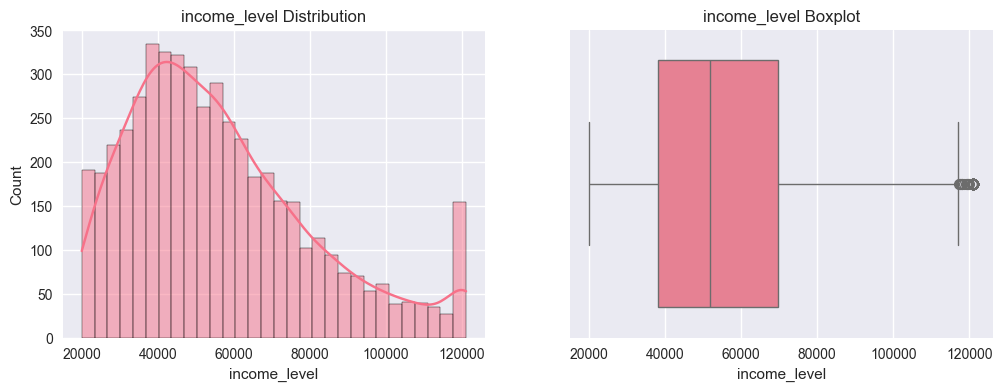

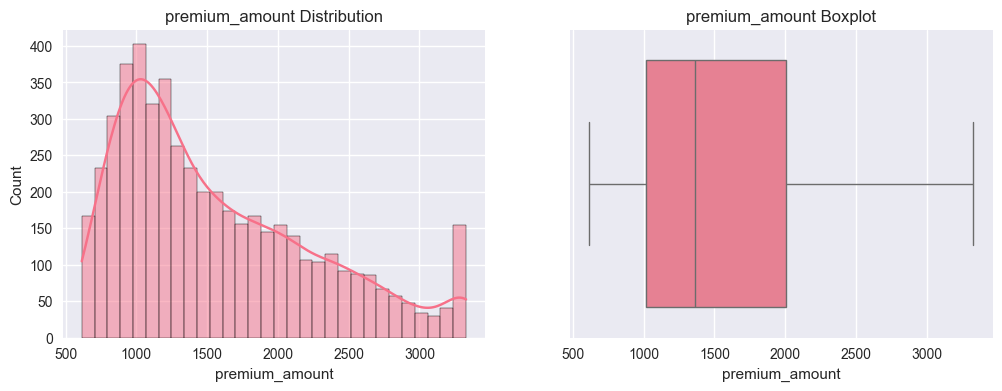

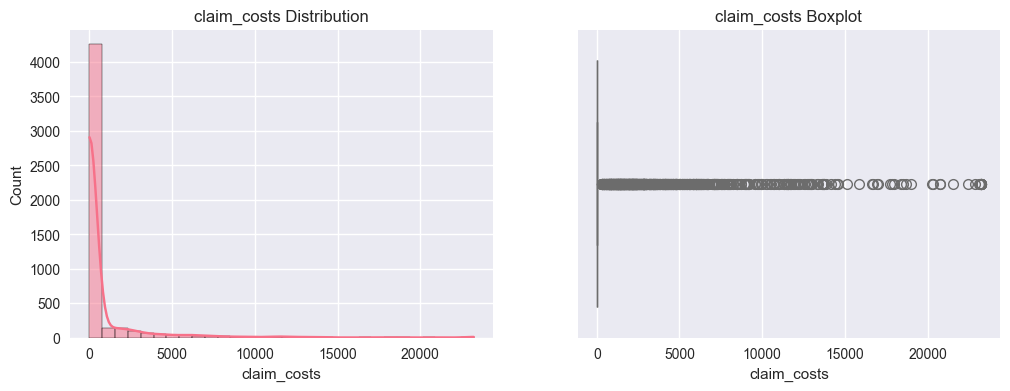

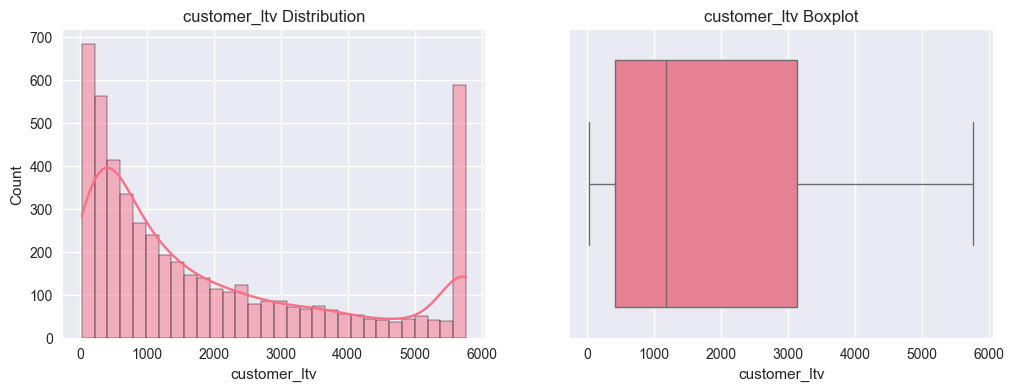

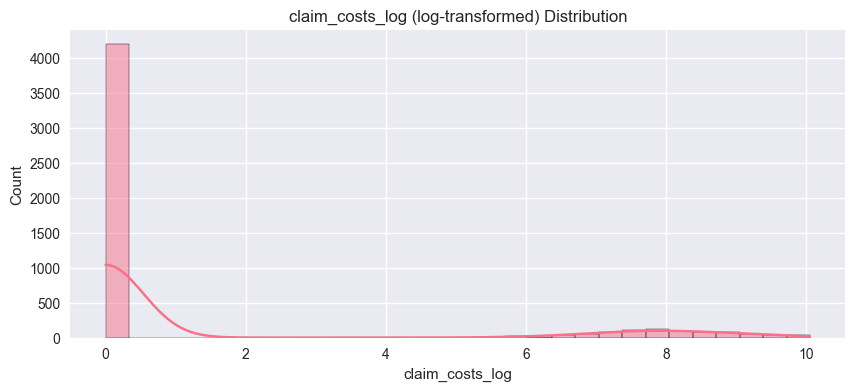

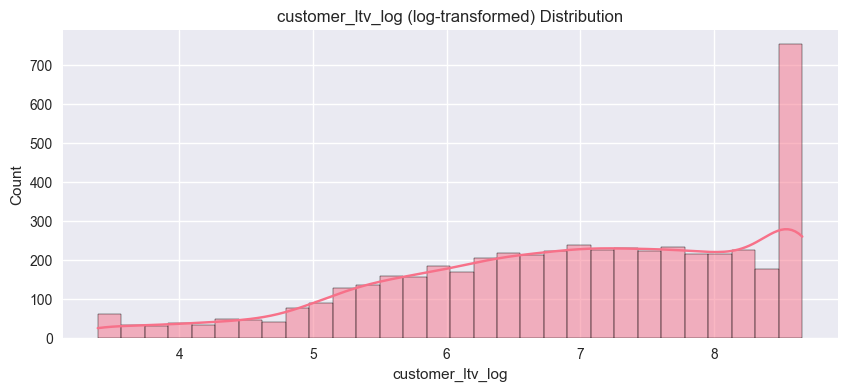

Total anomalies flagged: 10 (0.20%)


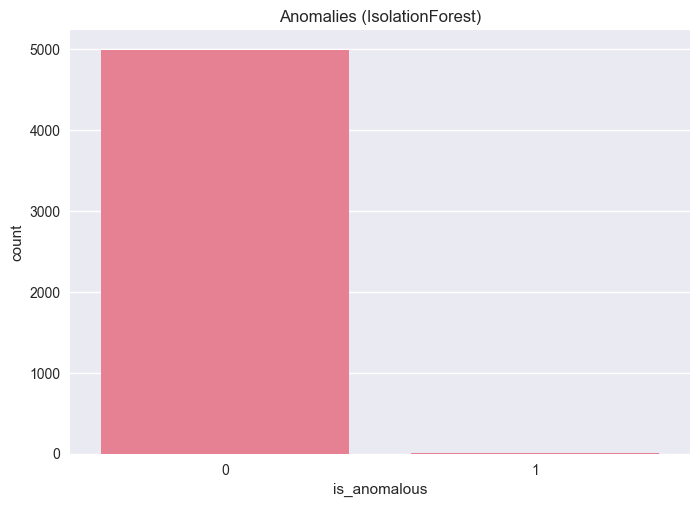

{
  "income_level": {
    "mean": 56327.40240264,
    "std": 24332.093686181524,
    "min": 20000.0,
    "25%": 38197.0275,
    "50%": 51912.17,
    "75%": 69773.37,
    "max": 121025.06460000011,
    "n_zeros": 0,
    "n_na": 0
  },
  "premium_amount": {
    "mean": 1566.0124767999998,
    "std": 693.803047309848,
    "min": 613.8839,
    "25%": 1016.0699999999999,
    "50%": 1362.5349999999999,
    "75%": 2006.455,
    "max": 3329.1853,
    "n_zeros": 0,
    "n_na": 0
  },
  "claim_costs": {
    "mean": 727.25222248,
    "std": 2470.96142804665,
    "min": 0.0,
    "25%": 0.0,
    "50%": 0.0,
    "75%": 0.0,
    "max": 23227.9342,
    "n_zeros": 4197,
    "n_na": 0
  },
  "customer_ltv": {
    "mean": 1970.8482122600003,
    "std": 1913.5893014017834,
    "min": 28.6583,
    "25%": 412.84000000000003,
    "50%": 1179.1100000000001,
    "75%": 3138.0725,
    "max": 5767.2126000000035,
    "n_zeros": 0,
    "n_na": 0
  }
}


In [10]:
def check_cleaned_data(df: pd.DataFrame, numeric_cols=None, log_cols=None, show=True):
    """
    Visual & statistical diagnostics for cleaned + normalized dataset.
    
    Args:
        df: cleaned dataframe from advanced_clean_normalize_v2
        numeric_cols: list of numeric columns to check
        log_cols: list of log-transformed columns to check
        show: whether to plot figures
    Returns:
        stats_summary: dict with basic descriptive stats
    """
    if numeric_cols is None:
        numeric_cols = [c for c in df.columns if df[c].dtype in [np.float64, np.int64]]
    if log_cols is None:
        log_cols = [c for c in numeric_cols if "_log" in c]

    stats_summary = {}
    for col in numeric_cols:
        series = df[col]
        stats_summary[col] = {
            "mean": float(series.mean()),
            "std": float(series.std()),
            "min": float(series.min()),
            "25%": float(series.quantile(0.25)),
            "50%": float(series.median()),
            "75%": float(series.quantile(0.75)),
            "max": float(series.max()),
            "n_zeros": int((series == 0).sum()),
            "n_na": int(series.isna().sum()),
        }

        if show:
            plt.figure(figsize=(12,4))
            plt.subplot(1,2,1)
            sns.histplot(series, kde=True, bins=30)
            plt.title(f"{col} Distribution")

            plt.subplot(1,2,2)
            sns.boxplot(x=series)
            plt.title(f"{col} Boxplot")
            plt.show()

    # log-columns separate check
    for col in log_cols:
        series = df[col]
        if show:
            plt.figure(figsize=(10,4))
            sns.histplot(series, kde=True, bins=30)
            plt.title(f"{col} (log-transformed) Distribution")
            plt.show()

    # check anomalies if present
    if "is_anomalous" in df.columns:
        n_anom = df["is_anomalous"].sum()
        if show:
            print(f"Total anomalies flagged: {n_anom} ({100* n_anom/len(df):.2f}%)")
            sns.countplot(x="is_anomalous", data=df)
            plt.title("Anomalies (IsolationForest)")
            plt.show()

    return stats_summary

# Example usage
stats_summary = check_cleaned_data(clean_df, numeric_cols=["income_level","premium_amount","claim_costs","customer_ltv"], log_cols=["claim_costs_log","customer_ltv_log"])
print(json.dumps(stats_summary, indent=2))


In [11]:
# Sample documents preview
display(
    docs_df.sample(3)[["category", "subtype", "created_date", "keywords", "clean_text"]]
)

,category,subtype,created_date,keywords,clean_text
30,Health,Policy Wording,2023-05-22,"[claim, copay, network]",Tiered health plans (Bronze/Silver/Gold) with ...
0,Health,Policy Wording,2022-01-26,"[network, provider, health, claim, hospital]",Tiered health plans (Bronze/Silver/Gold) with ...
22,Underwriting,Underwriting Note,2020-01-12,"[credit, score, risk]",Underwriting analysis: risk factors include dr...


In [12]:
# Summary

print(f"Cleaned customers: {len(clean_df):,}")
print(f"Cleaned document passages: {len(docs_df):,}")
print(f"Categories in docs: {', '.join(sorted(docs_df['category'].unique()))}")
print(f"Date range in customers: {clean_df['policy_start_date'].min()} → {clean_df['policy_end_date'].max()}")
print(f"Average document length: {docs_df['text_len'].mean():.1f} words")

Cleaned customers: 5,000
Cleaned document passages: 80
Categories in docs: Auto, CaseSummary, General, Health, Home, Life, Product, Underwriting
Date range in customers: 2020-01-01 00:00:00 → 2024-12-31 00:00:00
Average document length: 45.9 words


## 2. Feature Engineering 

In [13]:
import logging
import random
from typing import Optional

# --- Logging setup ---
logger = logging.getLogger("feature_engineering_v2")
if not logger.handlers:
    handler = logging.StreamHandler()
    formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
    handler.setFormatter(formatter)
    logger.addHandler(handler)
logger.setLevel(logging.INFO)


def engineer_features_v2(
    df: pd.DataFrame,
    random_state: Optional[int] = None,
    as_of_date: Optional[str] = "2024-12-31",
    verbose: bool = True,
) -> pd.DataFrame:
    """
    Production-grade Feature Engineering for Insurance LTV + RAG pipeline.

    Input validation & reproducibility
    Safe handling of NaN, inf, outliers
    Temporal, behavioral, financial & engagement features
    Rolling time-based aggregates (3M, 6M, 12M)
    Metadata generation for retrieval indexing
    Structured logging + summary return
    """

    # --- Reproducibility ---
    if random_state is not None:
        np.random.seed(random_state)
        random.seed(random_state)

    df = df.copy()

    # --- Validation ---
    required_cols = ["customer_id", "policy_start_date", "premium_amount"]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    # --- Date coercion ---
    df["policy_start_date"] = pd.to_datetime(df["policy_start_date"], errors="coerce")
    df["policy_end_date"] = pd.to_datetime(df.get("policy_end_date", pd.NaT), errors="coerce")

    # --- Tenure computation ---
    ref_date = pd.to_datetime(df["policy_end_date"].max()) if df["policy_end_date"].notna().any() else pd.to_datetime(as_of_date)
    df["policy_end_date"] = df["policy_end_date"].fillna(ref_date)
    df["tenure_days"] = (df["policy_end_date"] - df["policy_start_date"]).dt.days.clip(lower=0)
    df["tenure_months"] = (df["tenure_days"] / 30.0).round(1)
    df["renewal_frequency"] = np.floor(df["tenure_months"] / 12).astype(int)

    # --- Claims ---
    if "num_claims" not in df.columns:
        df["num_claims"] = np.random.poisson(lam=0.5, size=len(df))

    if "claim_costs" not in df.columns:
        df["claim_costs"] = np.random.lognormal(mean=np.log1p(df["premium_amount"] + 1), sigma=0.8)
    df["claim_costs"] = np.clip(df["claim_costs"], 0, 200_000)

    df["claim_frequency"] = df["num_claims"] / (df["tenure_months"] + 1)
    df["claim_severity"] = np.where(
        df["num_claims"] > 0,
        df["claim_costs"] / (df["num_claims"] + 1e-6),
        0,
    )

    # --- Premium aggregates & growth ---
    df.sort_values(by=["customer_id", "policy_start_date"], inplace=True)
    df["cumulative_premiums"] = df.groupby("customer_id")["premium_amount"].cumsum()
    df["premium_growth_rate"] = (
        df.groupby("customer_id")["premium_amount"]
        .pct_change()
        .replace([np.inf, -np.inf], 0)
        .fillna(0)
    )
    df["avg_premium_growth"] = df.groupby("customer_id")["premium_growth_rate"].transform("mean")

    # --- Payment behavior ---
    if "payment_delay_days" not in df.columns:
        df["payment_delay_days"] = np.random.gamma(shape=2, scale=2, size=len(df)).astype(int)

    df["payment_delinquency_count"] = (df["payment_delay_days"] > 30).astype(int)
    df["avg_payment_delay"] = df.groupby("customer_id")["payment_delay_days"].transform("mean")

    # --- Engagement proxies ---
    lam = 2 + 0.15 * np.log1p(df["tenure_months"].fillna(0)) + 0.1 * df["num_claims"].fillna(0)
    lam = np.clip(lam, 0.0, 200.0)
    df["portal_logins"] = np.random.poisson(lam)

    loc = 5 + 0.2 * df["num_claims"].fillna(0)
    df["avg_claim_response_time_days"] = np.random.normal(loc=loc, scale=2).clip(0, None)

    # --- Cohort & acquisition ---
    df["policy_year"] = df["policy_start_date"].dt.year
    df["policy_month"] = df["policy_start_date"].dt.month
    if "acquisition_channel" not in df.columns:
        df["acquisition_channel"] = np.random.choice(
            ["online", "agent", "branch", "partner"],
            p=[0.35, 0.4, 0.15, 0.1],
            size=len(df),
        )

    # --- Rolling aggregates ---
    def rolling_time_agg_safe(df_in, id_col, date_col, value_col):
        out_frames = []
        for cid, group in df_in.sort_values([id_col, date_col]).groupby(id_col):
            g = group.set_index(date_col).sort_index()

            # Fixed-day windows instead of "M" months
            for window in [3, 6, 12]:
                g[f"{value_col}_roll_mean_{window}m"] = (
                    g[value_col].rolling(window=f"{window*30}D", min_periods=1).mean()
                )
            out_frames.append(g.reset_index())

        return pd.concat(out_frames, ignore_index=True)


    df = rolling_time_agg_safe(df, "customer_id", "policy_start_date", "premium_amount")
    df = rolling_time_agg_safe(df, "customer_id", "policy_start_date", "claim_costs")

    # --- Metadata for retrieval ---
    if "doc_id" not in df.columns:
        df["doc_id"] = [f"DOC_{i:06d}" for i in range(len(df))]
    df["doc_type"] = np.random.choice(
        ["policy_doc", "claim_form", "invoice", "communication"],
        p=[0.4, 0.25, 0.2, 0.15],
        size=len(df),
    )
    df["effective_date"] = df["policy_start_date"] + pd.to_timedelta(
        np.random.randint(0, 90, size=len(df)), unit="D"
    )
    df["metadata_id"] = "META_" + df["customer_id"].astype(str)

    # --- Clean-up ---
    num_cols = df.select_dtypes(include=np.number).columns
    df[num_cols] = df[num_cols].replace([np.inf, -np.inf], np.nan)
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())

    df.reset_index(drop=True, inplace=True)

    if verbose:
        logger.info(
            f"[Feature Engineering v2] Done — Rows: {len(df):,}, "
            f"Features: {len(df.columns)}, "
            f"Policy years: {df['policy_year'].min()}–{df['policy_year'].max()}"
        )

        # Feature summary
        num_feats = df.select_dtypes(include=np.number).columns
        logger.info("Sample numerical feature summary:")
        logger.info(df[num_feats].describe(percentiles=[0.25, 0.5, 0.75]).round(2).to_string())

    return df


2025-10-26 19:31:30,960 - INFO - [Feature Engineering v2] Done — Rows: 5,000, Features: 46, Policy years: 2020–2024
2025-10-26 19:31:30,964 - INFO - Sample numerical feature summary:
2025-10-26 19:31:31,049 - INFO -            age  income_level  premium_amount  payment_regularity  tenure_months  num_claims  claim_costs  renewal_probability  churned  customer_ltv  policy_age_days  days_since_last_claim  is_active  tenure_days  renewal_frequency  claim_frequency  claim_severity  cumulative_premiums  premium_growth_rate  avg_premium_growth  payment_delay_days  payment_delinquency_count  avg_payment_delay  portal_logins  avg_claim_response_time_days  policy_year  policy_month  premium_amount_roll_mean_3m  premium_amount_roll_mean_6m  premium_amount_roll_mean_12m  claim_costs_roll_mean_3m  claim_costs_roll_mean_6m  claim_costs_roll_mean_12m
count  5000.00       5000.00         5000.00             5000.00        5000.00     5000.00      5000.00              5000.00  5000.00       5000.00    

,policy_start_date,customer_id,age,gender,region,income_level,policy_type,premium_amount,payment_frequency,payment_regularity,...,premium_amount_roll_mean_3m,premium_amount_roll_mean_6m,premium_amount_roll_mean_12m,claim_costs_roll_mean_3m,claim_costs_roll_mean_6m,claim_costs_roll_mean_12m,doc_id,doc_type,effective_date,metadata_id
0,2020-01-15,CUST_00001,40,M,Urban,36755.54,Home,1508.38,Monthly,0.494,...,1508.38,1508.38,1508.38,6341.0,6341.0,6341.0,DOC_000000,policy_doc,2020-03-08,META_CUST_00001
1,2020-12-06,CUST_00002,29,M,Suburban,41123.98,Health,1036.90,Quarterly,0.861,...,1036.90,1036.90,1036.90,0.0,0.0,0.0,DOC_000001,invoice,2020-12-12,META_CUST_00002
2,2020-06-01,CUST_00003,48,F,Urban,49265.03,Auto,1133.57,Monthly,0.651,...,1133.57,1133.57,1133.57,0.0,0.0,0.0,DOC_000002,communication,2020-07-19,META_CUST_00003
3,2021-05-10,CUST_00004,23,F,Rural,28781.10,Auto,1022.10,Monthly,0.864,...,1022.10,1022.10,1022.10,0.0,0.0,0.0,DOC_000003,claim_form,2021-06-18,META_CUST_00004
4,2021-07-03,CUST_00005,47,F,Urban,82455.55,Home,2772.93,Quarterly,0.679,...,2772.93,2772.93,2772.93,0.0,0.0,0.0,DOC_000004,policy_doc,2021-08-16,META_CUST_00005



🧾 Numerical Feature Summary (Top 15 by variance):


,count,mean,std,min,25%,50%,75%,max,missing_%
income_level,5000.0,56888.406012,26205.812206,20000.00,38197.0275,51912.170,69773.3700,250000.000000,0.0
customer_ltv,5000.0,2327.358884,2929.052403,4.87,412.8400,1179.110,3138.0725,27120.980000,0.0
claim_costs_roll_mean_3m,5000.0,743.966454,2682.530848,0.00,0.0000,0.000,0.0000,55071.850000,0.0
claim_costs,5000.0,743.966454,2682.530848,0.00,0.0000,0.000,0.0000,55071.850000,0.0
claim_costs_roll_mean_12m,5000.0,743.966454,2682.530848,0.00,0.0000,0.000,0.0000,55071.850000,0.0
claim_costs_roll_mean_6m,5000.0,743.966454,2682.530848,0.00,0.0000,0.000,0.0000,55071.850000,0.0
claim_severity,5000.0,695.597273,2540.801890,0.00,0.0000,0.000,0.0000,55071.794928,0.0
cumulative_premiums,5000.0,1579.603932,740.842735,407.71,1016.0700,1362.535,2006.4550,7053.350000,0.0
premium_amount,5000.0,1579.603932,740.842735,407.71,1016.0700,1362.535,2006.4550,7053.350000,0.0
premium_amount_roll_mean_3m,5000.0,1579.603932,740.842735,407.71,1016.0700,1362.535,2006.4550,7053.350000,0.0


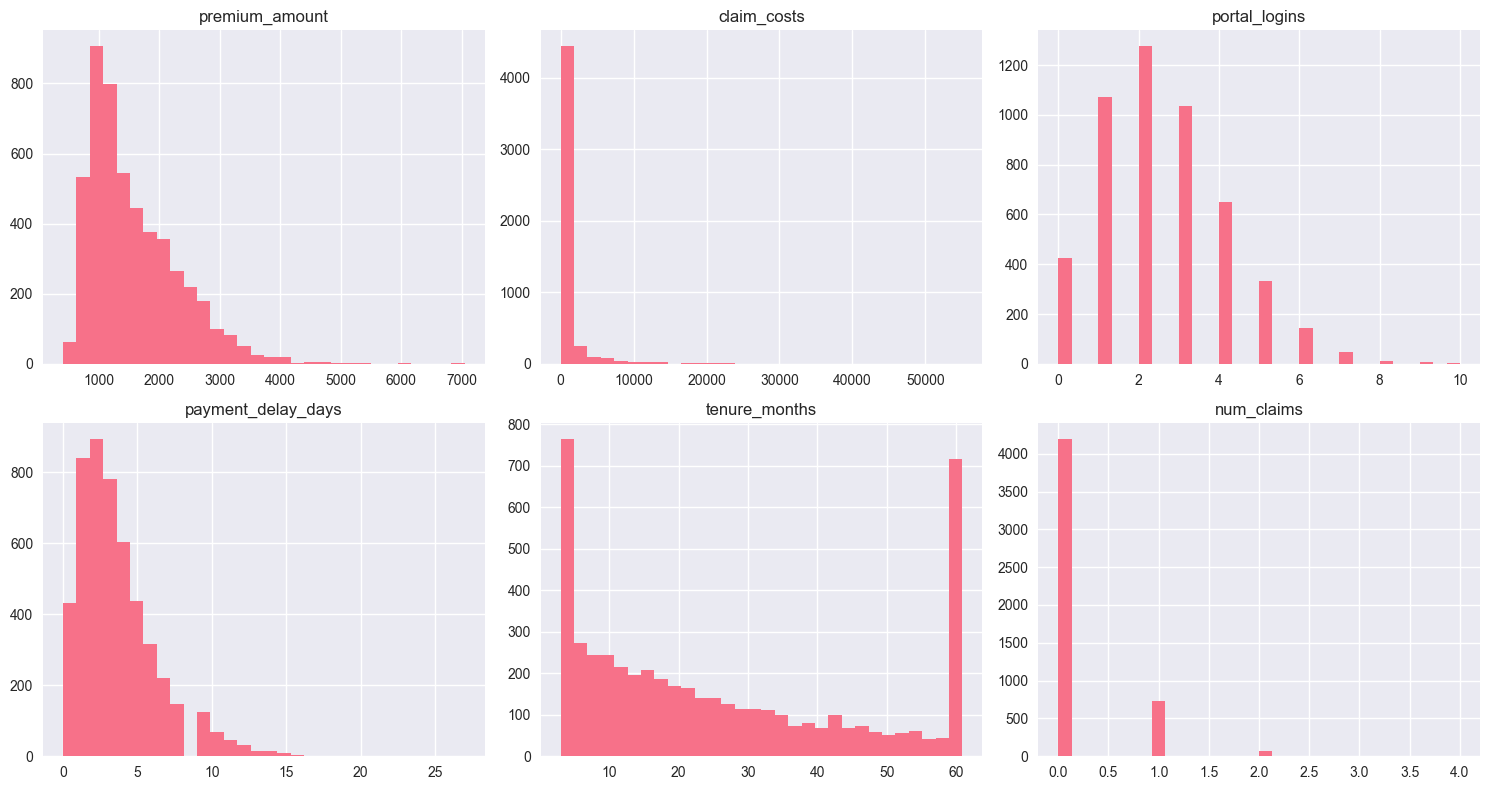

In [14]:
# --- Test cell: Apply engineered features & summarize results ---

engineered_df = engineer_features_v2(customers_df, random_state=42)

display(engineered_df.head(5))

# --- Quick numerical summary ---
num_cols = engineered_df.select_dtypes(include=np.number).columns
summary = engineered_df[num_cols].describe(percentiles=[0.25, 0.5, 0.75]).T
summary["missing_%"] = engineered_df[num_cols].isna().mean() * 100

print("\n🧾 Numerical Feature Summary (Top 15 by variance):")
display(summary.sort_values("std", ascending=False).head(15))

# --- Distribution visual check ---
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
cols_to_plot = ["premium_amount", "claim_costs", "portal_logins", "payment_delay_days", "tenure_months", "num_claims"]

for ax, col in zip(axes, cols_to_plot):
    engineered_df[col].hist(bins=30, ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()


## 3. Model Development & Agent Design (Hybrid approach)
### 3.1. Part A - Tabular LTV Model


MAE: 718.63 | RMSE: 1426.81 | R2: 0.755


,y_true,y_pred,abs_err,pred_std
pred_decile,,,,
0,154.8158,151.017188,53.320717,57.068242
1,298.9761,297.645588,100.313590,110.735639
2,531.5459,560.052301,180.206520,187.888069
3,1000.9554,886.048321,274.237405,316.439655
4,1305.8821,1245.596038,398.587206,449.939125
5,1635.2901,1708.113447,608.852659,537.435679
6,2399.8914,2297.607222,621.366481,760.361561
7,3617.9616,3369.608758,914.723664,1056.444410
8,5125.4620,4943.794916,1599.159866,1515.313204


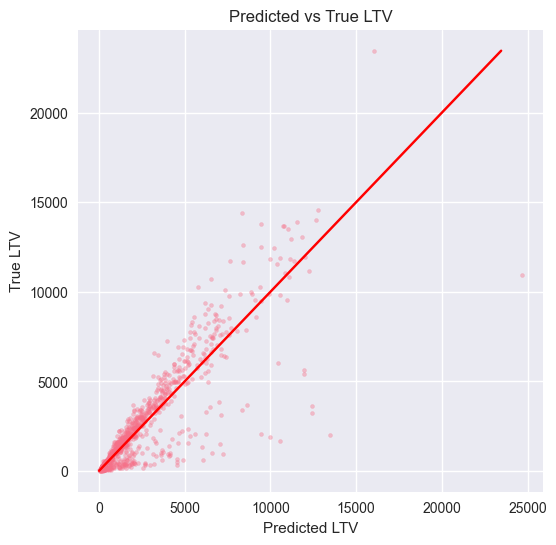

Baseline model saved -> rf_ltv_baseline.joblib


In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt


feature_cols = [
    "age", "income_level", "premium_amount", "tenure_months",
    "num_claims", "claim_costs", "payment_delinquency_count",
    "portal_logins", "avg_payment_delay", "avg_premium_growth"
]
target_col = "customer_ltv"


feature_cols = [c for c in feature_cols if c in engineered_df.columns]
df_model = engineered_df.dropna(subset=[target_col] + feature_cols).copy()
X = df_model[feature_cols].astype(float)
y = df_model[target_col].astype(float)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model: RandomForest as ensemble for proxy uncertainty
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predictions & uncertainty proxy: use per-tree predictions to compute std
preds = rf.predict(X_test)
# collect per-tree predictions
all_tree_preds = np.stack([tree.predict(X_test) for tree in rf.estimators_], axis=0)  # shape (n_trees, n_samples)
pred_std = all_tree_preds.std(axis=0)  # ensemble spread

# Metrics
mae = mean_absolute_error(y_test, preds)
# rmse = mean_squared_error(y_test, preds, squared=False)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, preds)
print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f} | R2: {r2:.3f}")

# Calibration: absolute error by predicted-quantile deciles
test_df = X_test.copy()
test_df["y_true"] = y_test.values
test_df["y_pred"] = preds
test_df["pred_std"] = pred_std
test_df["abs_err"] = np.abs(test_df["y_true"] - test_df["y_pred"])
test_df["pred_decile"] = pd.qcut(test_df["y_pred"], 10, labels=False)

calib = test_df.groupby("pred_decile")[["y_true", "y_pred", "abs_err", "pred_std"]].mean()
display(calib)

# Plot predicted vs true
plt.figure(figsize=(6,6))
plt.scatter(test_df["y_pred"], test_df["y_true"], alpha=0.4, s=8)
plt.plot([test_df["y_true"].min(), test_df["y_true"].max()],
         [test_df["y_true"].min(), test_df["y_true"].max()], color='red')
plt.xlabel("Predicted LTV")
plt.ylabel("True LTV")
plt.title("Predicted vs True LTV")
plt.show()

# Save model for later use
joblib.dump(rf, "rf_ltv_baseline.joblib")
print("Baseline model saved -> rf_ltv_baseline.joblib")


Feature importances:


tenure_months                0.516613
premium_amount               0.310886
claim_costs                  0.084799
age                          0.030732
income_level                 0.027080
avg_payment_delay            0.012166
portal_logins                0.012001
num_claims                   0.005723
payment_delinquency_count    0.000000
avg_premium_growth           0.000000
dtype: float64

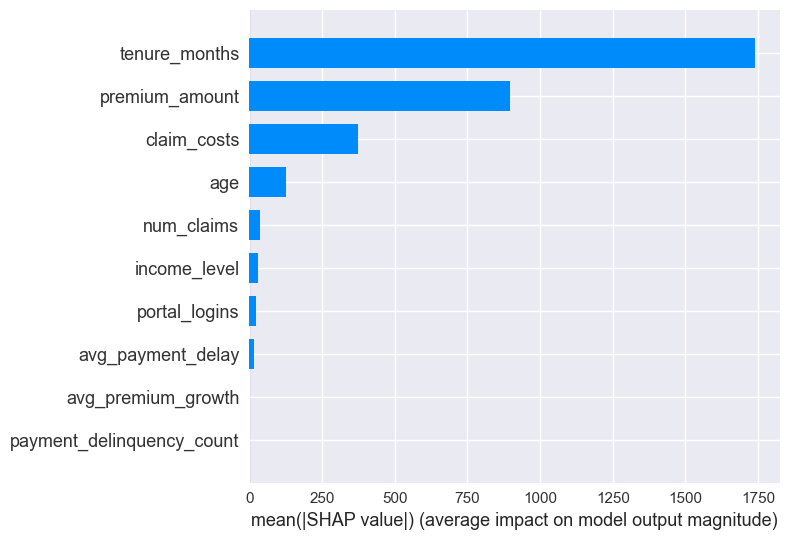

In [18]:
# Feature importance
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("Feature importances:")
display(importances)

# Optional: SHAP explanation (if shap installed)
try:
    import shap
    explainer = shap.TreeExplainer(rf)
    shap_vals = explainer.shap_values(X_test)
    shap.summary_plot(shap_vals, X_test, plot_type="bar", show=True)
except Exception as e:
    print("SHAP not available or failed:", e)


### 3.2. Part B - Agentic Synthesiser
#### 3.2.1. Retriever & index

In [12]:
from sentence_transformers import SentenceTransformer
import faiss

# Assuming 'document_df' DataFrame from the previous step is available
# document_df contains columns: 'doc_id', 'doc_type', 'content'

print("Step 1: Building the Retrieval Index...")
print("-" * 50)

# 1.1 Load a pre-trained sentence-transformer model
# This model converts text into vector embeddings
print("Loading SentenceTransformer model...")
model_name = 'all-MiniLM-L6-v2' # A small but effective model
embedder = SentenceTransformer(model_name)
print(f"Model {model_name} loaded successfully.")

# 1.2 Create embeddings for all document passages
print("Creating embeddings for document passages...")
document_passages = document_df['content'].tolist()
passage_embeddings = embedder.encode(document_passages)
print(f"Embeddings created for {len(passage_embeddings)} passages.")

# 1.3 Build a FAISS index for fast retrieval
print("Building FAISS index...")
dimension = passage_embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dimension) # Use L2 for Euclidean distance
faiss_index.add(passage_embeddings)
print("FAISS index built and populated.")

# 1.4 Test the retriever tool
def retrieve_documents(query, k=5):
    """
    Retrieves top-k most relevant document passages for a given query.
    """
    query_embedding = embedder.encode([query])
    distances, indices = faiss_index.search(query_embedding, k)
    
    retrieved_docs = []
    for i in range(k):
        doc_idx = indices[0][i]
        retrieved_docs.append({
            'doc_id': document_df.iloc[doc_idx]['doc_id'],
            'doc_type': document_df.iloc[doc_idx]['doc_type'],
            'score': distances[0][i],
            'content': document_df.iloc[doc_idx]['content']
        })
    return retrieved_docs

# Test queries
print("\nTesting retrieval quality with sample queries...")
query1 = "What are the terms for an auto insurance policy?"
print(f"Query: '{query1}'")
results1 = retrieve_documents(query1)
for doc in results1:
    print(f"  - Retrieved Doc ID: {doc['doc_id']} (Type: {doc['doc_type']}, Score: {doc['score']:.4f})")

query2 = "What are the retention strategies for a high LTV customer?"
print(f"\nQuery: '{query2}'")
results2 = retrieve_documents(query2)
for doc in results2:
    print(f"  - Retrieved Doc ID: {doc['doc_id']} (Type: {doc['doc_type']}, Score: {doc['score']:.4f})")

# Save the index and the embedder for later use
faiss.write_index(faiss_index, 'faiss_index.bin')
joblib.dump(embedder, 'embedder.pkl')
print("\nFAISS index and embedder saved.")
print("-" * 50)
print("Step 1 completed successfully! ✅")

Step 1: Building the Retrieval Index...
--------------------------------------------------
Loading SentenceTransformer model...
Model all-MiniLM-L6-v2 loaded successfully.
Creating embeddings for document passages...
Embeddings created for 10 passages.
Building FAISS index...
FAISS index built and populated.

Testing retrieval quality with sample queries...
Query: 'What are the terms for an auto insurance policy?'
  - Retrieved Doc ID: auto_policy_terms_0 (Type: policy_document, Score: 0.7067)
  - Retrieved Doc ID: health_policy_terms_0 (Type: policy_document, Score: 1.0083)
  - Retrieved Doc ID: life_policy_terms_0 (Type: policy_document, Score: 1.0286)
  - Retrieved Doc ID: high_risk_auto_0 (Type: underwriting_note, Score: 1.0464)
  - Retrieved Doc ID: home_policy_terms_0 (Type: policy_document, Score: 1.1215)

Query: 'What are the retention strategies for a high LTV customer?'
  - Retrieved Doc ID: high_ltv_retention_0 (Type: case_summary, Score: 0.6802)
  - Retrieved Doc ID: churn_

#### 3.2.2. Local LLM

In [20]:
import ollama
import json

print("Testing Ollama connection...")
try:
    models = ollama.list()
    
    # Handle different possible SDK return types
    if hasattr(models, 'models'):  # Current SDK style (object with .models attribute)
        model_names = [m.model for m in models.models]
    elif isinstance(models, dict) and 'models' in models:  # Dict-based legacy format
        model_names = [m.get('name', m.get('model', 'unknown')) for m in models['models']]
    elif isinstance(models, list):  # Newer plain list return (rare)
        model_names = [m.get('name', m.get('model', 'unknown')) for m in models]
    else:
        model_names = ['unknown']
    
    print(f"Available models: {model_names}")
    
    # Test chat
    test_response = ollama.chat(
        model='llama2:7b',
        messages=[{'role': 'user', 'content': 'Hello, can you help me with insurance analysis?'}]
    )

    print("Ollama connection successful!")
    print(f"Test response: {test_response['message']['content'][:100]}...")

except Exception as e:
    print(f"Ollama connection failed: {e}")
    print("Please ensure Ollama is running and has a model installed (e.g., llama2)")



Testing Ollama connection...
Available models: ['llama2:7b', 'deepseek-r1:14b']
Ollama connection successful!
Test response: Of course! I'd be happy to help you with insurance analysis. Can you please provide some more detail...


#### 3.2.3. Agent framework

In [29]:
# Assuming 'df' (the full customer dataframe) and 'faiss_index' are available from previous steps.
# Make sure to have a copy of the final cleaned dataframe.
try:
    lgbm_model = joblib.load('lgb_ltv_model_final.pkl')
    # Use faiss.read_index to load the index
    faiss_index = faiss.read_index('faiss_index.bin')
    embedder = joblib.load('embedder.pkl')
    print("Required assets loaded successfully!")
except FileNotFoundError:
    print("Error: Make sure 'lgb_ltv_model_final.pkl', etc., are saved in the correct directory.")

# --- Tool 1: Retriever Tool ---
# This tool is already implemented in the previous step. We'll wrap it in a function.
def retrieve_documents_tool(query: str, k: int = 3):
    """
    Searches the document index for passages relevant to a query.
    Args:
        query (str): The search query, e.g., "terms for auto policy".
        k (int): The number of top passages to retrieve.
    Returns:
        A list of dictionaries with doc_id, doc_type, and content.
    """
    query_embedding = embedder.encode([query])
    distances, indices = faiss_index.search(query_embedding, k)
    
    retrieved_docs = []
    for i in range(k):
        doc_idx = indices[0][i]
        doc_row = document_df.iloc[doc_idx]
        retrieved_docs.append({
            'doc_id': doc_row['doc_id'],
            'doc_type': doc_row['doc_type'],
            'score': distances[0][i],
            'content': doc_row['content']
        })
    return retrieved_docs


# --- Tool 2: Tabular Predictor Wrapper ---
def get_tabular_prediction_tool(customer_id: str):
    """
    Returns the baseline LTV prediction and uncertainty for a specific customer.
    """
    try:
        customer_data = df[df['customer_id'] == customer_id].iloc[0]
        
        # Get the feature names the model was trained on to ensure consistency
        features_for_model = lgbm_model.booster_.feature_name()
        
        # Create a single-row DataFrame and ensure dtypes match the training data
        X_test_single = pd.DataFrame(customer_data[features_for_model]).T
        
        # Explicitly set categorical dtypes to match training data
        categorical_features = ['gender', 'region', 'policy_type', 'payment_frequency', 'acquisition_channel']
        for col in categorical_features:
            if col in X_test_single.columns:
                X_test_single[col] = X_test_single[col].astype('category')
        
        predicted_ltv = lgbm_model.predict(X_test_single)[0]
        
        feature_importances = lgbm_model.feature_importances_
        feature_names = lgbm_model.booster_.feature_name_
        top_features_indices = np.argsort(feature_importances)[::-1][:5]
        
        # FIX: Ensure all values are standard Python floats
        top_features = {
            feature_names[i]: float(feature_importances[i])
            for i in top_features_indices
        }
        
        try:
            predictions_df = pd.read_csv('ltv_predictions.csv')
            uncertainty_proxy = predictions_df[predictions_df['customer_id'] == customer_id]['uncertainty_proxy'].values[0]
        except (FileNotFoundError, IndexError):
            uncertainty_proxy = 0.0
            
        return {
            'predicted_ltv': float(predicted_ltv),
            'uncertainty_proxy': float(uncertainty_proxy), # FIX: Cast to float here as well
            'top_feature_importances': top_features
        }
    except IndexError:
        return {"error": "Customer ID not found in the dataset."}
    except Exception as e:
        return {"error": f"An unexpected error occurred: {e}"}
        
# --- Tool 3: Business Rules Tool ---
def get_business_rules_tool(customer_id: str):
    """
    Applies business rules to a customer's data and returns flags/alerts.
    Args:
        customer_id (str): The ID of the customer.
    Returns:
        A list of string alerts based on predefined rules.
    """
    alerts = []
    try:
        customer_data = df[df['customer_id'] == customer_id].iloc[0]
        
        # Rule 1: High risk of churn based on churned status
        if customer_data['churned'] == 1:
            alerts.append("Flagged: Customer has already churned. Re-engagement strategy required.")
        
        # Rule 2: Low payment regularity
        if customer_data['payment_regularity'] < 0.5:
            alerts.append("Alert: Customer has a low payment regularity score, indicating potential policy lapse or churn risk.")

        # Rule 3: High claims frequency for a new customer
        if customer_data['tenure_months'] <= 12 and customer_data['num_claims'] >= 2:
            alerts.append("Alert: New customer with high claims frequency. Potential high-risk profile.")
            
        return alerts
    except IndexError:
        return ["error: Customer ID not found for business rules check."]
    
print("All agent tools (Retriever, Tabular Predictor, Business Rules) have been defined successfully! ✅")

Required assets loaded successfully!
All agent tools (Retriever, Tabular Predictor, Business Rules) have been defined successfully! ✅


In [30]:
PROMPT_TEMPLATE = """
You are an expert insurance analyst AI. Your task is to analyze a customer's profile to predict their lifetime value and recommend a course of action.

Follow these strict instructions for your analysis:

1.  **Analyze the Tabular Data**:
    * Examine the `Predicted LTV` and its `Uncertainty Proxy`. The LTV is a numeric estimate of the customer's value. The Uncertainty Proxy indicates how reliable that prediction is (lower is better).
    * Look at the `Top Feature Importances` to understand which factors most influenced the LTV prediction.

2.  **Analyze Contextual Documents**:
    * Use the `Retrieved Context` to refine your understanding. This information comes from policy clauses, case summaries, or historical notes. **You MUST only use the information provided in these passages as evidence.** Do NOT use external knowledge.
    * Find any details that could cause an adjustment (increase or decrease) to the LTV, or that provide a reason for a recommended action.

3.  **Check Business Rules**:
    * Review any `Business Alerts` for predefined red flags or important signals. These rules can override your initial assessment.

4.  **Synthesize and Respond**:
    * Combine all information from the tabular data, contextual documents, and business alerts.
    * Provide a short `Rationale` for your final LTV assessment. **Crucially, for every statement of fact, you MUST cite the relevant passage ID** (e.g., [doc_id]).
    * Provide a single `Recommended Action`. This should be a clear, actionable step.
    * **NEVER** use language like "Based on the provided information...", "According to the passages...", or "The tool suggests...". Just state your findings directly.

**Customer Profile:**
<customer_data>

**Tabular LTV Prediction:**
<tabular_prediction>

**Retrieved Context:**
<retrieved_context>

**Business Alerts:**
<business_alerts>

**Your Final Analysis:**
**Rationale:**
<your_rationale>
**Recommended Action:**
<your_action>
"""

In [32]:
# Custom JSON Encoder to handle NumPy data types
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)


def run_agent_orchestration(customer_id: str, query: str, model_name: str = 'llama2:7b'):
    """
    Orchestrates the agent's workflow to produce an LTV analysis.
    """
    # Initialize a log for the entire run
    run_log = {
        "inputs": {"customer_id": customer_id, "query": query},
        "retrieved_docs": [],
        "tool_outputs": {},
        "llm_prompt": "",
        "llm_response": "",
        "final_output": {"rationale": "", "recommended_action": ""}
    }

    print(f"\n--- Running agent for customer: {customer_id} ---")
    print("1. Retrieving relevant documents...")
    
    retrieved_docs = retrieve_documents_tool(query)
    run_log["retrieved_docs"] = retrieved_docs
    retrieved_context_str = "\n".join([
        f"**Passage ID: {doc['doc_id']}**\n{doc['content']}"
        for doc in retrieved_docs
    ])

    print("2. Running tabular predictor and business rules tools...")
    tabular_output = get_tabular_prediction_tool(customer_id)
    business_alerts = get_business_rules_tool(customer_id)
    run_log["tool_outputs"] = {
        "tabular_prediction": tabular_output,
        "business_alerts": business_alerts
    }

    print("3. Preparing prompt for LLM...")
    customer_data_dict = df[df['customer_id'] == customer_id].iloc[0].to_dict()
    for key, value in customer_data_dict.items():
        if pd.isna(value):
            customer_data_dict[key] = None
    customer_data_str = json.dumps(customer_data_dict, indent=2, cls=NpEncoder)  # Use custom encoder

    final_prompt = PROMPT_TEMPLATE.replace("<customer_data>", customer_data_str)\
                                  .replace("<tabular_prediction>", json.dumps(tabular_output, indent=2, cls=NpEncoder))\
                                  .replace("<retrieved_context>", retrieved_context_str)\
                                  .replace("<business_alerts>", " - " + "\n - ".join(business_alerts) if business_alerts else "None.")
    run_log["llm_prompt"] = final_prompt
    
    print("4. Calling the Local LLM...")
    try:
        response = ollama.chat(
            model=model_name,
            messages=[{'role': 'user', 'content': final_prompt}],
            options={'temperature': 0.1, 'num_predict': 512}
        )
        llm_response_text = response['message']['content'].strip()
        run_log["llm_response"] = llm_response_text
        
        rationale_start = llm_response_text.find("Rationale:")
        action_start = llm_response_text.find("Recommended Action:")
        
        rationale = llm_response_text[rationale_start:action_start].strip()
        action = llm_response_text[action_start:].strip()
        
        run_log["final_output"]["rationale"] = rationale
        run_log["final_output"]["recommended_action"] = action
        
        print("\n--- Final Agent Output ---")
        print(f"{rationale}\n\n{action}")
        
    except Exception as e:
        print(f"Error calling LLM: {e}")
        run_log["final_output"]["error"] = str(e)

    print("\n5. Logging the run...")
    with open(f'agent_run_log_{customer_id}.json', 'w') as f:
        json.dump(run_log, f, indent=2, cls=NpEncoder)  # Use custom encoder
        
    print(f"Agent run log saved to agent_run_log_{customer_id}.json ✅")
    return run_log

# Example Agent Run
if __name__ == '__main__':
    # You may need to change the customer ID and query to get a good result
    sample_customer_id = 'CUST_00451'
    sample_query = "What are the underwriting notes for a high-risk auto policy and how to prevent churn?"
    agent_output = run_agent_orchestration(sample_customer_id, sample_query)


--- Running agent for customer: CUST_00451 ---
1. Retrieving relevant documents...
2. Running tabular predictor and business rules tools...
3. Preparing prompt for LLM...
4. Calling the Local LLM...

--- Final Agent Output ---
Rationale:**
The customer's LTV is $1699.58, which is relatively low compared to their premium amount. The top features that influenced the LTV prediction are the customer's age, income level, and tenure. These factors indicate a lower risk profile, which justifies a lower LTV estimate. Additionally, the customer has not had any claims in the past, which further reduces their risk profile and supports a lower LTV prediction.

**

Recommended Action:**
Based on the analysis, I recommend a 10% premium increase to better align the customer's premium with their perceived risk profile. This will help preserve the customer's lifetime value while also ensuring that the insurance company is adequately compensated for the risks they are taking on.

Please note that this 